In [ ]:
!pip install datasets
!pip install transformers peft datasets accelerate bitsandbytes
!pip install gdown

In [ ]:
import numpy as np
import pandas as pd
import torch
import json
import gdown
from datasets import Dataset, load_dataset, concatenate_datasets
from transformers import Trainer, TrainingArguments, BertTokenizer, AutoModelForCausalLM, AutoTokenizer, GenerationConfig
from torch.utils.data import DataLoader, Subset
from sklearn.metrics import accuracy_score
from peft import LoraConfig, get_peft_model

In [ ]:
from huggingface_hub import notebook_login

notebook_login()

Initialize model 1 (to be fine-tuned without CL)

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# we chose this small model
# model = AutoModelForCausalLM.from_pretrained('roneneldan/TinyStories-1M')
# model = AutoModelForCausalLM.from_pretrained("TinyLlama/TinyLlama_v1.1")
# tokenizer = AutoTokenizer.from_pretrained("TinyLlama/TinyLlama_v1.1")

# model_name = "meta-llama/Llama-2-7b"
model_name = "meta-llama/Llama-3.2-3B"
tokenizer = AutoTokenizer.from_pretrained(model_name)

from transformers import BitsAndBytesConfig

quant_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_use_double_quant=True,
    bnb_4bit_quant_type="nf4",
)

tokenizer.pad_token = tokenizer.eos_token

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/50.5k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.09M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/301 [00:00<?, ?B/s]

In [ ]:
# Configure LoRA
lora_config = LoraConfig(
    r=8,  # Low-rank dimension
    lora_alpha=32,  # Scaling factor
    target_modules=["q_proj", "v_proj"],  # Apply LoRA to specific transformer layers
    lora_dropout=0.1,  # Dropout for stability
    bias="none",  # Don't modify bias terms
    task_type="CAUSAL_LM"  # Task type for LLaMA 2
)

In [ ]:
model = AutoModelForCausalLM.from_pretrained(
    model_name,
    device_map="auto",
    quantization_config=quant_config,
)

config.json:   0%|          | 0.00/844 [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/20.9k [00:00<?, ?B/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/4.97G [00:00<?, ?B/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/1.46G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/185 [00:00<?, ?B/s]

In [ ]:
# Add LoRA adapters to the model
model = get_peft_model(model, lora_config)

# Check the number of trainable parameters
model.print_trainable_parameters()

trainable params: 2,293,760 || all params: 3,215,043,584 || trainable%: 0.0713


#Preprocessing OFFICIAL inputs before tokenizing

In [ ]:
def process_file(file_name):
      with open(file_name, 'r') as f:
        data = json.load(f)
      transformed_data = [{"text": item["question"], "label": item["answer"]} for item in data]

      # Convert the list of dictionaries into a HuggingFace Dataset object
      dataset = Dataset.from_dict({
          "text": [item["text"] for item in transformed_data],
          "label": [item["label"] for item in transformed_data]
      })
      return dataset

def tokenize_function(examples):
    return tokenizer(
        examples["text"],
        padding="max_length",
        truncation=True,
        max_length=200,
        return_tensors="pt")

def shifting(examples):
    # examples['label'] = examples['input_ids'][1:]+[examples['label']]

    shifted_labels = []
    for input_ids, true_label in zip(examples['input_ids'], examples['label']):
        # Shift input_ids by removing the first token and adding the true label at the end
        shifted_label = input_ids[1:] + [true_label]
        shifted_labels.append(shifted_label)

    # Update the examples with the new shifted labels
    examples['labels'] = shifted_labels
    return examples


def preprocess(file_name):
    examples = process_file(file_name)
    examples = examples.shuffle(seed=42)
    columns_to_remove = [col for col in examples.column_names if col != 'label']

    tokenized_dataset = examples.map(
        tokenize_function,
        batched=True,
        remove_columns=columns_to_remove  # Remove the original columns except labels
    )
    print(type(tokenized_dataset['input_ids']))

    tokenized_dataset = tokenized_dataset.map(shifting, batched=True)

    tokenized_dataset.set_format("torch")
    return tokenized_dataset

In [ ]:
url = "https://drive.google.com/uc?id=1T6uUtzuo5bIyc4EI239UZacue8XR9v76"
file_id = "1T6uUtzuo5bIyc4EI239UZacue8XR9v76"
gdown.download(url, 'allsub_easy.json', quiet=False)

url = "https://drive.google.com/uc?id=1NabBNnhf5ZA8oVFvcRePJ1GsfSbcDUc_"
file_id = "1NabBNnhf5ZA8oVFvcRePJ1GsfSbcDUc_"
gdown.download(url, 'allsub_medium.json', quiet=False)

url = "https://drive.google.com/uc?id=1iQ1dSyywxRbwPhfpDJ7XNz80rVZLZRk-"
file_id = "1iQ1dSyywxRbwPhfpDJ7XNz80rVZLZRk"
gdown.download(url, 'allsub_hard.json', quiet=False)

url = "https://drive.google.com/uc?id=1L-YY03BVFWMWAynIdlX__LsKxgpc8w-y"
file_id = "1L-YY03BVFWMWAynIdlX__LsKxgpc8w-y"
gdown.download(url, 'allsub_test.json', quiet=False)

Downloading...
From: https://drive.google.com/uc?id=1T6uUtzuo5bIyc4EI239UZacue8XR9v76
To: /content/allsub_easy.json
100%|██████████| 111k/111k [00:00<00:00, 50.5MB/s]
Downloading...
From: https://drive.google.com/uc?id=1NabBNnhf5ZA8oVFvcRePJ1GsfSbcDUc_
To: /content/allsub_medium.json
100%|██████████| 104k/104k [00:00<00:00, 62.8MB/s]
Downloading...
From: https://drive.google.com/uc?id=1iQ1dSyywxRbwPhfpDJ7XNz80rVZLZRk-
To: /content/allsub_hard.json
100%|██████████| 102k/102k [00:00<00:00, 63.0MB/s]
Downloading...
From: https://drive.google.com/uc?id=1L-YY03BVFWMWAynIdlX__LsKxgpc8w-y
To: /content/allsub_test.json
100%|██████████| 105k/105k [00:00<00:00, 72.9MB/s]


'allsub_test.json'

##Preprocessing Subject Specific Data

In [ ]:
import zipfile
import os

In [ ]:
# Specify the path to the uploaded ZIP file
zip_file_path = '/content/train.zip'  # Replace with the correct filename

# Extract the ZIP file
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall('/myfolder')  # Extracts to '/content/your_folder'

print("Folder extracted successfully!")

# Check the contents of the folder
print(os.listdir('/myfolder'))
print(os.listdir('/myfolder/train'))

Folder extracted successfully!
['__MACOSX', 'train']
['phys', 'cs', 'chem', 'bio', 'math', '.DS_Store']


In [ ]:
### Instructions: upload files first
subject = "phys" #bio, chem, cs, math, phys

easy = preprocess(f"/myfolder/train/{subject}/easy.json")
medium = preprocess(f"/myfolder/train/{subject}/medium.json")
hard = preprocess(f"/myfolder/train/{subject}/hard.json")
test_hard = preprocess(f"val_{subject}.json")

Map:   0%|          | 0/50 [00:00<?, ? examples/s]

<class 'list'>


Map:   0%|          | 0/50 [00:00<?, ? examples/s]

Map:   0%|          | 0/50 [00:00<?, ? examples/s]

<class 'list'>


Map:   0%|          | 0/50 [00:00<?, ? examples/s]

Map:   0%|          | 0/50 [00:00<?, ? examples/s]

<class 'list'>


Map:   0%|          | 0/50 [00:00<?, ? examples/s]

Map:   0%|          | 0/50 [00:00<?, ? examples/s]

<class 'list'>


Map:   0%|          | 0/50 [00:00<?, ? examples/s]

# Shuffled Model

In [ ]:
in_order_data = concatenate_datasets([easy, medium, hard]) # not relevant for shuffled model
shuffled_data = in_order_data.shuffle(seed=42)
# print(shuffled_data[0])

# Training args

In [ ]:
!pip install evaluate

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.0/84.0 kB 2.4 MB/s eta 0:00:00


In [ ]:
# Define training arguments
training_args = TrainingArguments(
    output_dir="./lora_llama2_mmlu",
    evaluation_strategy="epoch",
    per_device_train_batch_size=16,
    per_device_eval_batch_size=8,
    # gradient_accumulation_steps=8,
    learning_rate=2e-4,
    num_train_epochs=10,
    save_strategy="no",
    logging_strategy="epoch",     # Ensures logs are printed after every epoch
    logging_dir="./logs",
    # logging_steps = 20,
    fp16=True,  # Use mixed precision for efficiency
    push_to_hub=False  # Set True if you want to save to Hugging Face Hub
)


import numpy as np
import evaluate

accuracy_metric = evaluate.load("accuracy")

def compute_metrics(eval_pred):
    logits, labels = eval_pred

    # Take the argmax over the last dimension to get token predictions
    predictions = np.argmax(logits, axis=-1)

    # Flatten predictions and labels for token-level accuracy
    predictions = predictions.flatten()
    labels = labels.flatten()

    # Ignore padding tokens (example assumes padding token ID is `-100`)
    mask = labels != -100
    predictions = predictions[mask]
    labels = labels[mask]

    # Compute accuracy
    accuracy = accuracy_metric.compute(predictions=predictions, references=labels)
    return {"accuracy": accuracy["accuracy"]}


/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1568: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [ ]:
from transformers import TrainerCallback

class MetricsTracker(TrainerCallback):
    def __init__(self):
        self.train_loss_list = []
        self.train_acc_list = []
        self.val_loss_list = []
        self.val_acc_list = []

    def on_log(self, args, state, control, logs=None, **kwargs):
        if logs is not None:
            if "loss" in logs:
                self.train_loss_list.append(logs["loss"])
            if "accuracy" in logs:
                self.train_acc_list.append(logs["accuracy"])
            if "eval_loss" in logs:
                self.val_loss_list.append(logs["eval_loss"])
            if "eval_accuracy" in logs:
                self.val_acc_list.append(logs["eval_accuracy"])

# Evaluate non-fine-tuned model

In [ ]:
def process_file_new(file_name):
    with open(file_name, 'r') as f:
        data = json.load(f)

    # Handle both old and new JSON structures
    if isinstance(data, list):
        # Old format: list of dictionaries
        items = data
    else:
        # New format: dictionary with numbered keys
        items = [data[key] for key in data.keys()]

    transformed_data = [{"text": item["question"], "label": item["answer"]} for item in items]

    # Convert the list of dictionaries into a HuggingFace Dataset object
    dataset = Dataset.from_dict({
        "text": [item["text"] for item in transformed_data],
        "label": [item["label"] for item in transformed_data]
    })
    return dataset

def preprocess_new(file_name):
    examples = process_file_new(file_name)
    examples = examples.shuffle(seed=42)
    columns_to_remove = [col for col in examples.column_names if col != 'label']

    tokenized_dataset = examples.map(
        tokenize_function,
        batched=True,
        remove_columns=columns_to_remove  # Remove the original columns except labels
    )
    print(type(tokenized_dataset['input_ids']))

    tokenized_dataset = tokenized_dataset.map(shifting, batched=True)

    tokenized_dataset.set_format("torch")
    return tokenized_dataset

In [ ]:
pre_metrics_tracker = MetricsTracker()

pre_trainer = Trainer(
    model=model,
    args=training_args,
    eval_dataset=test_hard,
    compute_metrics=compute_metrics,
    callbacks=[pre_metrics_tracker]
)

regular_val = preprocess(f"val_{subject}.json")
results = pre_trainer.evaluate(eval_dataset=regular_val)
print(results)

iccl_val = preprocess_new(f"iccl_val_{subject}.json")
results = pre_trainer.evaluate(eval_dataset=iccl_val)
print(results)

icl_random_val = preprocess_new(f"icl_random_val_{subject}.json")
results = pre_trainer.evaluate(eval_dataset=icl_random_val)
print(results)

icl_all_hard_val = preprocess_new(f"icl_all_hard_val_{subject}.json")
results = pre_trainer.evaluate(eval_dataset=icl_all_hard_val)
print(results)

Map:   0%|          | 0/50 [00:00<?, ? examples/s]

<class 'list'>


Map:   0%|          | 0/50 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/bitsandbytes/nn/modules.py:451: UserWarning: Input type into Linear4bit is torch.float16, but bnb_4bit_compute_dtype=torch.float32 (default). This will lead to slow inference or training speed.
  warnings.warn(


wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.
wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

 ··········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


{'eval_loss': 10.933745384216309, 'eval_model_preparation_time': 0.0033, 'eval_accuracy': 0.2731, 'eval_runtime': 6.5211, 'eval_samples_per_second': 7.667, 'eval_steps_per_second': 1.073}


Map:   0%|          | 0/50 [00:00<?, ? examples/s]

<class 'list'>


Map:   0%|          | 0/50 [00:00<?, ? examples/s]

{'eval_loss': 9.52401351928711, 'eval_model_preparation_time': 0.0033, 'eval_accuracy': 0.6486, 'eval_runtime': 5.1373, 'eval_samples_per_second': 9.733, 'eval_steps_per_second': 1.363}


Map:   0%|          | 0/50 [00:00<?, ? examples/s]

<class 'list'>


Map:   0%|          | 0/50 [00:00<?, ? examples/s]

{'eval_loss': 9.689785957336426, 'eval_model_preparation_time': 0.0033, 'eval_accuracy': 0.6518, 'eval_runtime': 5.1156, 'eval_samples_per_second': 9.774, 'eval_steps_per_second': 1.368}


Map:   0%|          | 0/50 [00:00<?, ? examples/s]

<class 'list'>


Map:   0%|          | 0/50 [00:00<?, ? examples/s]

{'eval_loss': 10.218759536743164, 'eval_model_preparation_time': 0.0033, 'eval_accuracy': 0.5864, 'eval_runtime': 5.1417, 'eval_samples_per_second': 9.724, 'eval_steps_per_second': 1.361}


# Shuffled

In [ ]:
# Set up Trainer
metrics_tracker = MetricsTracker()

trainer = Trainer(
    model=model,
    args=training_args,
    # train_dataset=train_data_shufflemodel,
    # eval_dataset=test_data_shufflemodel
    # train_dataset=concatenate_datasets([easy, medium, hard]).shuffle(seed=42),
    train_dataset=shuffled_data,
    eval_dataset=test_hard,
    compute_metrics=compute_metrics,
    callbacks=[metrics_tracker]
)

# Start training
trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy
1,7.115600,3.811179,0.815100
2,3.397900,2.475131,0.715500
3,2.267500,1.884594,0.736800
4,1.814800,1.572937,0.657200
5,1.599200,1.448185,0.632000
6,1.457600,1.384536,0.619700
7,1.350800,1.343237,0.610600
8,1.262900,1.317135,0.605000
9,1.231900,1.308098,0.600000
10,1.197200,1.303832,0.600000


TrainOutput(global_step=100, training_loss=2.2695469570159914, metrics={'train_runtime': 100.5729, 'train_samples_per_second': 14.915, 'train_steps_per_second': 0.994, 'total_flos': 5077874073600000.0, 'train_loss': 2.2695469570159914, 'epoch': 10.0})

In [ ]:
model.save_pretrained("./math_nocl")
# Evaluate on the test set
results = trainer.evaluate(eval_dataset=test_hard)
print(results)

{'eval_loss': 1.303831934928894, 'eval_accuracy': 0.6, 'eval_runtime': 5.1254, 'eval_samples_per_second': 9.755, 'eval_steps_per_second': 1.366, 'epoch': 10.0}


In [ ]:
regular_val = preprocess(f"val_{subject}.json")
results = trainer.evaluate(eval_dataset=regular_val)
print(results)

iccl_val = preprocess_new(f"iccl_val_{subject}.json")
results = trainer.evaluate(eval_dataset=iccl_val)
print(results)

icl_random_val = preprocess_new(f"icl_random_val_{subject}.json")
results = trainer.evaluate(eval_dataset=icl_random_val)
print(results)

icl_all_hard_val = preprocess_new(f"icl_all_hard_val_{subject}.json")
results = trainer.evaluate(eval_dataset=icl_all_hard_val)
print(results)

Map:   0%|          | 0/50 [00:00<?, ? examples/s]

<class 'list'>


Map:   0%|          | 0/50 [00:00<?, ? examples/s]

{'eval_loss': 1.303831934928894, 'eval_accuracy': 0.6, 'eval_runtime': 5.09, 'eval_samples_per_second': 9.823, 'eval_steps_per_second': 1.375, 'epoch': 10.0}


Map:   0%|          | 0/50 [00:00<?, ? examples/s]

<class 'list'>


Map:   0%|          | 0/50 [00:00<?, ? examples/s]

{'eval_loss': 3.2962801456451416, 'eval_accuracy': 0.0804, 'eval_runtime': 5.1219, 'eval_samples_per_second': 9.762, 'eval_steps_per_second': 1.367, 'epoch': 10.0}


Map:   0%|          | 0/50 [00:00<?, ? examples/s]

<class 'list'>


Map:   0%|          | 0/50 [00:00<?, ? examples/s]

{'eval_loss': 3.315601110458374, 'eval_accuracy': 0.0893, 'eval_runtime': 5.1329, 'eval_samples_per_second': 9.741, 'eval_steps_per_second': 1.364, 'epoch': 10.0}


Map:   0%|          | 0/50 [00:00<?, ? examples/s]

<class 'list'>


Map:   0%|          | 0/50 [00:00<?, ? examples/s]

{'eval_loss': 2.8908321857452393, 'eval_accuracy': 0.1852, 'eval_runtime': 5.1207, 'eval_samples_per_second': 9.764, 'eval_steps_per_second': 1.367, 'epoch': 10.0}


## Let's plot!

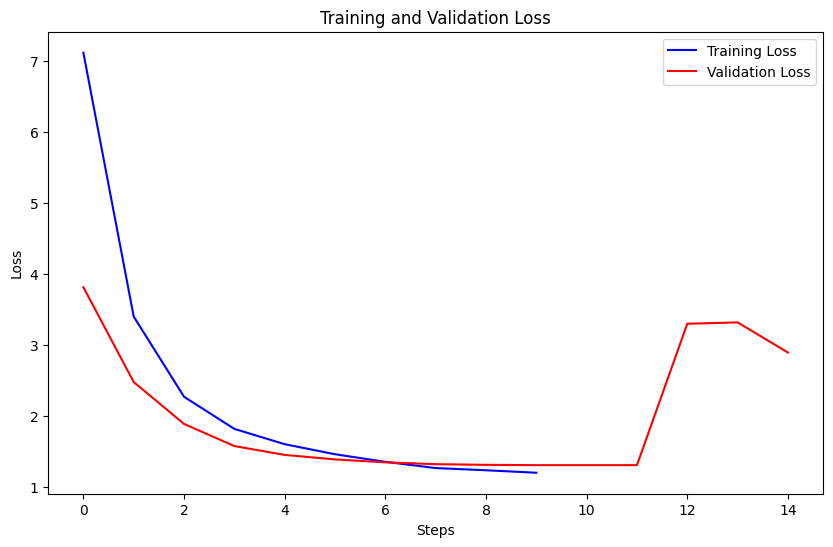

In [ ]:
import matplotlib.pyplot as plt

# Extract the log history from the trainer
log_history = trainer.state.log_history

# Lists to store training and validation losses
train_losses = []
eval_losses = []

# Loop through the log history and extract the relevant losses
for log in log_history:
    if 'loss' in log:
        train_losses.append(log['loss'])  # Training loss
    if 'eval_loss' in log:
        eval_losses.append(log['eval_loss'])  # Validation loss

# Plotting the losses
plt.figure(figsize=(10, 6))
plt.plot(train_losses, label='Training Loss', color='blue')
plt.plot(eval_losses, label='Validation Loss', color='red')
plt.xlabel('Steps')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

In [ ]:
train_loss_list = pre_metrics_tracker.train_loss_list
train_acc_list = pre_metrics_tracker.train_acc_list
val_loss_list = pre_metrics_tracker.val_loss_list
val_acc_list = pre_metrics_tracker.val_acc_list

print("Train Loss:", train_loss_list)
print("Train Accuracy:", train_acc_list)
print("Validation Loss:", val_loss_list)
print("Validation Accuracy:", val_acc_list)

Train Loss: []
Train Accuracy: []
Validation Loss: [10.933745384216309, 9.52401351928711, 9.689785957336426, 10.218759536743164]
Validation Accuracy: [0.2731, 0.6486, 0.6518, 0.5864]


In [ ]:
train_loss_list = metrics_tracker.train_loss_list
train_acc_list = metrics_tracker.train_acc_list
val_loss_list = metrics_tracker.val_loss_list
val_acc_list = metrics_tracker.val_acc_list

print("Train Loss:", train_loss_list)
print("Train Accuracy:", train_acc_list)
print("Validation Loss:", val_loss_list)
print("Validation Accuracy:", val_acc_list)

Train Loss: [7.1156, 3.3979, 2.2675, 1.8148, 1.5992, 1.4576, 1.3508, 1.2629, 1.2319, 1.1972]
Train Accuracy: []
Validation Loss: [3.8111793994903564, 2.475131034851074, 1.884594440460205, 1.5729366540908813, 1.448184847831726, 1.3845361471176147, 1.343237042427063, 1.317134976387024, 1.308098316192627, 1.303831934928894, 1.303831934928894, 1.303831934928894, 3.2962801456451416, 3.315601110458374, 2.8908321857452393]
Validation Accuracy: [0.8151, 0.7155, 0.7368, 0.6572, 0.632, 0.6197, 0.6106, 0.605, 0.6, 0.6, 0.6, 0.6, 0.0804, 0.0893, 0.1852]


# CL

We wish to train our model in three stages, using easy, medium, and hard math questions.

In [ ]:
model_cl = AutoModelForCausalLM.from_pretrained(
    model_name,
    device_map="auto",
    quantization_config=quant_config,
)

# Add LoRA adapters to the model
model_cl = get_peft_model(model_cl, lora_config)

# Check the number of trainable parameters
model_cl.print_trainable_parameters()

config.json:   0%|          | 0.00/844 [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/20.9k [00:00<?, ?B/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/4.97G [00:00<?, ?B/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/1.46G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/185 [00:00<?, ?B/s]

trainable params: 2,293,760 || all params: 3,215,043,584 || trainable%: 0.0713


In [ ]:
# Create a function to train the model sequentially using Curriculum Learning
eval_metrics_tracker = MetricsTracker()

def train_curriculum_model(model, easy, medium, hard, test_data, training_args):
    # Split data into stages for Curriculum Learning: Easy -> Medium -> Hard
    stage_data = [easy, medium, hard]  # List of datasets in increasing difficulty

    for stage in range(len(stage_data)):
        # For each stage, train the model on the corresponding difficulty level
        current_stage_data = stage_data[stage]

        # Train the model on the current stage data
        cl_trainer = Trainer(
            model=model,
            args=training_args,
            train_dataset=current_stage_data,
            eval_dataset=test_data,
            compute_metrics=compute_metrics,
            callbacks=[eval_metrics_tracker]
        )

        print(f"Training on stage {stage + 1} (difficulty: {['easy', 'medium', 'hard'][stage]})")
        cl_trainer.train()

    return model


# Train the model on the curriculum data (easy -> medium -> hard)
trained_model = train_curriculum_model(model_cl, easy, medium, hard, test_hard, training_args)

# Evaluate the trained model on the test set (same for all stages)
eval_trainer = Trainer(
    model=trained_model,
    args=training_args,
    eval_dataset=test_hard,
    compute_metrics=compute_metrics,
    callbacks=[eval_metrics_tracker]
)
eval_trainer.evaluate()

wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.


Training on stage 1 (difficulty: easy)


wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

 ··········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


/usr/local/lib/python3.10/dist-packages/bitsandbytes/nn/modules.py:451: UserWarning: Input type into Linear4bit is torch.float16, but bnb_4bit_compute_dtype=torch.float32 (default). This will lead to slow inference or training speed.
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy
1,9.646800,7.819050,0.273200
2,6.103700,4.145614,0.816900
3,4.529400,3.590815,0.813300
4,3.829500,3.104313,0.796800
5,3.363400,2.694918,0.762900
6,2.807000,2.411244,0.734600
7,2.504500,2.225335,0.739600
8,2.514400,2.112735,0.741000
9,2.574500,2.040096,0.743100
10,2.222500,2.000286,0.742300


Training on stage 2 (difficulty: medium)


Epoch,Training Loss,Validation Loss,Accuracy
1,1.763600,1.723722,0.678300
2,1.714700,1.608998,0.657800
3,1.407800,1.542925,0.635900
4,1.317800,1.506308,0.632900
5,1.231400,1.484529,0.623200
6,1.207000,1.471073,0.622300
7,1.234600,1.470150,0.615500
8,1.144800,1.464990,0.614300
9,1.162300,1.461354,0.613000
10,1.223400,1.462976,0.611800


Training on stage 3 (difficulty: hard)


Epoch,Training Loss,Validation Loss,Accuracy
1,1.387100,1.417079,0.621900
2,1.242500,1.359521,0.610900
3,1.241400,1.343105,0.595900
4,1.091200,1.319297,0.594100
5,1.040000,1.314782,0.589500
6,0.939800,1.313485,0.588300
7,0.962400,1.326535,0.584600
8,0.899100,1.330550,0.585200
9,0.851300,1.334311,0.585300
10,0.893800,1.337402,0.584600


{'eval_loss': 1.3374024629592896,
 'eval_model_preparation_time': 0.0034,
 'eval_accuracy': 0.5846,
 'eval_runtime': 5.1381,
 'eval_samples_per_second': 9.731,
 'eval_steps_per_second': 1.362}

In [ ]:
regular_val = preprocess(f"val_{subject}.json")
results = eval_trainer.evaluate(eval_dataset=regular_val)
print(results)

iccl_val = preprocess_new(f"iccl_val_{subject}.json")
results = eval_trainer.evaluate(eval_dataset=iccl_val)
print(results)

icl_random_val = preprocess_new(f"icl_random_val_{subject}.json")
results = eval_trainer.evaluate(eval_dataset=icl_random_val)
print(results)

icl_all_hard_val = preprocess_new(f"icl_all_hard_val_{subject}.json")
results = eval_trainer.evaluate(eval_dataset=icl_all_hard_val)
print(results)

Map:   0%|          | 0/50 [00:00<?, ? examples/s]

<class 'list'>


Map:   0%|          | 0/50 [00:00<?, ? examples/s]

{'eval_loss': 1.3374024629592896, 'eval_model_preparation_time': 0.0034, 'eval_accuracy': 0.5846, 'eval_runtime': 5.0988, 'eval_samples_per_second': 9.806, 'eval_steps_per_second': 1.373}


Map:   0%|          | 0/50 [00:00<?, ? examples/s]

<class 'list'>


Map:   0%|          | 0/50 [00:00<?, ? examples/s]

{'eval_loss': 3.7834386825561523, 'eval_model_preparation_time': 0.0034, 'eval_accuracy': 0.068, 'eval_runtime': 5.1102, 'eval_samples_per_second': 9.784, 'eval_steps_per_second': 1.37}


Map:   0%|          | 0/50 [00:00<?, ? examples/s]

<class 'list'>


Map:   0%|          | 0/50 [00:00<?, ? examples/s]

{'eval_loss': 3.6162121295928955, 'eval_model_preparation_time': 0.0034, 'eval_accuracy': 0.072, 'eval_runtime': 5.0924, 'eval_samples_per_second': 9.819, 'eval_steps_per_second': 1.375}


Map:   0%|          | 0/50 [00:00<?, ? examples/s]

<class 'list'>


Map:   0%|          | 0/50 [00:00<?, ? examples/s]

{'eval_loss': 2.965527296066284, 'eval_model_preparation_time': 0.0034, 'eval_accuracy': 0.167, 'eval_runtime': 5.0955, 'eval_samples_per_second': 9.813, 'eval_steps_per_second': 1.374}


In [ ]:
train_loss_list = eval_metrics_tracker.train_loss_list
train_acc_list = eval_metrics_tracker.train_acc_list
val_loss_list = eval_metrics_tracker.val_loss_list
val_acc_list = eval_metrics_tracker.val_acc_list

print("Train Loss:", train_loss_list)
print("Train Accuracy:", train_acc_list)
print("Validation Loss:", val_loss_list)
print("Validation Accuracy:", val_acc_list)

Train Loss: [9.6468, 6.1037, 4.5294, 3.8295, 3.3634, 2.807, 2.5045, 2.5144, 2.5745, 2.2225, 1.7636, 1.7147, 1.4078, 1.3178, 1.2314, 1.207, 1.2346, 1.1448, 1.1623, 1.2234, 1.3871, 1.2425, 1.2414, 1.0912, 1.04, 0.9398, 0.9624, 0.8991, 0.8513, 0.8938]
Train Accuracy: []
Validation Loss: [7.819050312042236, 4.145613670349121, 3.5908150672912598, 3.1043131351470947, 2.694918155670166, 2.4112439155578613, 2.225334882736206, 2.112734794616699, 2.040095567703247, 2.0002858638763428, 1.7237223386764526, 1.6089978218078613, 1.5429253578186035, 1.50630784034729, 1.4845291376113892, 1.471073031425476, 1.470150351524353, 1.464990258216858, 1.4613542556762695, 1.4629759788513184, 1.417078971862793, 1.3595210313796997, 1.343105435371399, 1.3192973136901855, 1.3147821426391602, 1.3134853839874268, 1.326534628868103, 1.330549716949463, 1.3343113660812378, 1.3374024629592896, 1.3374024629592896, 1.3374024629592896, 3.7834386825561523, 3.6162121295928955, 2.965527296066284]
Validation Accuracy: [0.2732, 